本文件使用SVC方法对figure.xlsx中的数据进行分类。

In [10]:
#首先读取figure.xlsx文件，第一列为标签，第二列为Y,第三列及以后为X

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#读取数据
data = pd.read_excel('figure.xlsx')
#将数据转为矩阵，第一行第一列为索引
data = data.values
#提取标签
smiles = data[1:, 0]
#提取X,Y
X = data[1:, 2:].astype(float)
Y = data[1:, 1].astype(int)
#划分训练集和测试集
X_train, X_test, y_true_train, y_true_test = train_test_split(X, Y, test_size=0.2)
X_train.shape, X_test.shape, y_true_train.shape, y_true_test.shape

((83, 11), (21, 11), (83,), (21,))

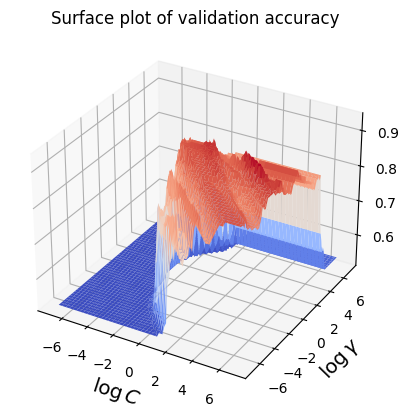

{'C': 35.111917342151344, 'gamma': 0.8111308307896873}

In [11]:


#对超参数`C`与`gamma`进行基于5-折交叉验证的网格搜索, 并对模型性能进行可视化.
from sklearn.model_selection import GridSearchCV
from typing import Tuple, Dict
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

def get_cv_data(
    C_space: np.ndarray, gamma_space: np.ndarray, X_train: np.ndarray, y_true_train: np.ndarray
) -> Tuple[Tuple[np.ndarray, np.ndarray, np.ndarray], Dict]:
    ### BEGIN YOUR SOLUTION ###
    #对C和gamma进行网格搜索，进行5折交叉验证
    param_grid = {'C': C_space, 'gamma': gamma_space}
    clf = SVC()
    ## 加入scoring参数
    grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_true_train)
    #返回值包含一个二元数组，第一个数组是C,gamma,score组成的数组，第二个数组是最佳参数组合
    #首先得到C
    C = grid_search.cv_results_['param_C']
    #reshape成二维数组
    C = C.reshape(len(C_space), len(gamma_space))
    #然后得到gamma
    gamma = grid_search.cv_results_['param_gamma']
    #reshape成二维数组
    gamma = gamma.reshape(len(C_space), len(gamma_space))
    #最后得到score，是一个二维数组
    score = grid_search.cv_results_['mean_test_score']
    #reshape成二维数组
    score = score.reshape(len(C_space), len(gamma_space))
    
    #将C,gamma,score组成一个数组
    cv_data = (C, gamma, score)
    #得到最佳参数组合，以字典形式返回
    best_params = grid_search.best_params_
    return cv_data, best_params
    ### END YOUR SOLUTION ###
    
#设置C和gamma的范围
C_space = np.logspace(-3, 3, 100)
gamma_space = np.logspace(-3, 3, 100)
#调用函数
(X, Y, Z), best_params = get_cv_data(C_space, gamma_space, X_train, y_true_train)

from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(np.log(X), np.log(Y), Z, cmap='coolwarm')
ax.set_xlabel(r'$\log{C}$', weight='bold', size='x-large')
ax.set_ylabel(r'$\log{\gamma}$', weight='bold', size='x-large')
ax.set_title("Surface plot of validation accuracy")
plt.show()

best_params

In [12]:
#使用最佳参数,训练模型
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
def train_and_predict(
    best_params: Dict, X_train: np.ndarray, y_true_train: np.ndarray, X_test: np.ndarray
) -> np.ndarray:
    #创建管道
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(**best_params))
    ])
    
    #训练模型
    pipe.fit(X_train, y_true_train)
    
    #预测与评估
    y_pred = pipe.predict(X_test)
    return y_pred


#调用函数
y_pred = train_and_predict(best_params, X_train, y_true_train, X_test)

#计算准确率
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true_test, y_pred)
print(f"Accuracy: {accuracy}")

#计算召回率
from sklearn.metrics import recall_score
recall = recall_score(y_true_test, y_pred, average='macro')
print(f"Recall: {recall}")

#计算精确率
from sklearn.metrics import precision_score
precision = precision_score(y_true_test, y_pred, average='macro')
print(f"Precision: {precision}")

#计算F1值
from sklearn.metrics import f1_score
f1 = f1_score(y_true_test, y_pred, average='macro')
print(f"F1: {f1}")







Accuracy: 0.8095238095238095
Recall: 0.8333333333333333
Precision: 0.8461538461538461
F1: 0.8090909090909091
